In [2]:
import pandas as pd
import pickle 
import numpy as np
from scipy.stats import binom
import jellyfish
from copy import deepcopy
from functools import reduce
import operator

In [3]:
# load files 
A = pd.read_csv('FileA.csv')
B = pd.read_csv('FileB.csv')

A = A[['firstname','lastname','streetname','birthyear']]
B = B[['firstname','lastname','streetname','birthyear']]


A.streetname = A.streetname.apply(lambda x : f' {x} ')
B.streetname = B.streetname.apply(lambda x : f' {x} ')

A

,firstname,lastname,streetname,birthyear
0,daniel,secuya,fairview ct,1957
1,david,motakabbir,shepherd ave apt 4,1971
2,joseph,joseph,piedmont ave,1948
3,joseph,mcnulty,49th ave,1961
4,akensheye,paniagua chavez,glenwood dr,1972
...,...,...,...,...
495,joseph,baclig,oxford st apt 206,1991
496,eric,ladd,carrison st apt d,1936
497,david,hinton,montecarlo park ct,1945
498,clifford,perry,valita dr,1961


In [4]:
# make pairs functions
def make_pairs(A,B):
    pairs = []

    for i in range(len(A)):
        a = pd.DataFrame(A.to_numpy()[[i]].repeat(len(B),axis=0))
        d =pd.concat([a,B],axis=1)
        pairs.append(d)
    pairs = pd.concat(pairs, axis=0).reset_index(drop=True)
    pairs.columns = [f'{col_name}_{d}' for d, cols in zip(['A','B'],[A.columns, B.columns]) for col_name in cols]
    return pairs

# name parsing
- in the case of firstname & lastname we can see there are names that has length shorter than 2
- but I will treat these names a partial information of the real name
- for further scoring, I will use soundex algorithm and levenshtein distance
- also I found there are one letter names, which seems like abbreviations.
    - I will reduce the firstname with the first letters

In [5]:
# 1) apply soundex algorithm
A_names = deepcopy(A[['firstname','lastname']])
B_names = deepcopy(B[['firstname','lastname']])

A_names[['firstname_soundex','lastname_soundex']]= A_names[['firstname','lastname']].applymap(jellyfish.soundex)
B_names[['firstname_soundex','lastname_soundex']]= B_names[['firstname','lastname']].applymap(jellyfish.soundex)
# now we will compute the hamming distance of firstname and lastname of A and B

A_names.head()

# we apply comparison of string distance using jaro-winkler similarity after making all pairs

,firstname,lastname,firstname_soundex,lastname_soundex
0,daniel,secuya,D540,S200
1,david,motakabbir,D130,M321
2,joseph,joseph,J210,J210
3,joseph,mcnulty,J210,M254
4,akensheye,paniagua chavez,A252,P522


In [6]:
# make pairs 
names_pair = make_pairs(A_names, B_names)

In [7]:
# calculate Hamming distance of soundex of each pair
# if the Hamming distance is smaller than 0.25 
# which means we allow 1 letter difference 

names_pair['firstname_hamming_score'] = ((names_pair.apply(lambda x : jellyfish.hamming_distance(x['firstname_soundex_A'],x['firstname_soundex_B']),axis=1) / 4) <= 0.25)*1
names_pair['lastname_hamming_score'] = ((names_pair.apply(lambda x : jellyfish.hamming_distance(x['lastname_soundex_A'],x['lastname_soundex_B']),axis=1) / 4) <= 0.25)*1


In [8]:
# 2) now we calculate the pairs with respect to simliarity
# we use jaro-winkler similarity

names_pair['firstname_similarity'] = (names_pair.apply(lambda x : jellyfish.jaro_winkler_similarity(x['firstname_A'],x['firstname_B']), axis=1) > 0.8)*1
names_pair['lastname_similarity'] = (names_pair.apply(lambda x : jellyfish.jaro_winkler_similarity(x['lastname_A'],x['lastname_B']), axis=1) > 0.8)*1


In [9]:
# 3) reduce the firstname with the first letter

A_names['front_letter'] = A_names.firstname.str.findall('^\w').apply(lambda x : x[0])
B_names['front_letter'] = B_names.firstname.str.findall('^\w').apply(lambda x : x[0])

df = make_pairs(A_names, B_names)
names_pair['front_letter_similarity'] = df.apply(lambda x: (x['front_letter_A'] == x['front_letter_B'])*1, axis=1)

In [10]:
names_pair

,firstname_A,lastname_A,firstname_soundex_A,lastname_soundex_A,firstname_B,lastname_B,firstname_soundex_B,lastname_soundex_B,firstname_hamming_score,lastname_hamming_score,firstname_similarity,lastname_similarity,front_letter_similarity
0,daniel,secuya,D540,S200,gurjot,greaney,G623,G650,0,0,0,0,0
1,daniel,secuya,D540,S200,harold,estrada,H643,E236,0,0,0,0,0
2,daniel,secuya,D540,S200,clarence,bailey,C465,B400,0,0,0,0,0
3,daniel,secuya,D540,S200,ian,niemeyer,I500,N560,0,0,0,0,0
4,daniel,secuya,D540,S200,jasbir,bauer,J216,B600,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174995,cristian,ghaemmaghami,C623,G525,f,willgins,F000,W425,0,0,0,0,0
174996,cristian,ghaemmaghami,C623,G525,doaron,janssen,D650,J525,0,1,0,0,0
174997,cristian,ghaemmaghami,C623,G525,jianbo,rose,J510,R200,0,0,0,0,0
174998,cristian,ghaemmaghami,C623,G525,christopher,fawsett,C623,F230,1,0,0,0,1


# Streetname Parsing
- we apply jaro-winkler algorithm to compare both strings

In [11]:
A_streetname = deepcopy(pd.DataFrame(A['streetname']))
B_streetname = deepcopy(pd.DataFrame(B['streetname']))

street_pairs = make_pairs(A_streetname,B_streetname)

street_pairs['street_string_similarity']= (street_pairs.apply(lambda x : jellyfish.jaro_winkler_similarity(x['streetname_A'], x['streetname_B']),axis=1) >= 0.9)*1

In [12]:
street_pairs

,streetname_A,streetname_B,street_string_similarity
0,fairview ct,blue fin way,0
1,fairview ct,cherry st apt 251,0
2,fairview ct,woolsey st,0
3,fairview ct,pepper st,0
4,fairview ct,pacific ave,0
...,...,...,...
174995,cameron hills ct,ruschin dr,0
174996,cameron hills ct,herriott ave,0
174997,cameron hills ct,marina blvd,0
174998,cameron hills ct,primrose dr,0


# birthyear parsing
- just compare the two numbers between pairs

In [13]:
A_birthyear = deepcopy(pd.DataFrame(A['birthyear']))
B_birthyear = deepcopy(pd.DataFrame(B['birthyear']))

birth_pairs = make_pairs(A_birthyear, B_birthyear)
birth_pairs['birthyear_similarity']= birth_pairs.apply(lambda x : (x['birthyear_A'] == x['birthyear_B'])*1, axis=1)

# concat the similarity columns

In [14]:
names_similarity = deepcopy(names_pair.loc[:,"firstname_hamming_score":])
street_similarity = pd.DataFrame(street_pairs['street_string_similarity'])
birth_similarity = pd.DataFrame(birth_pairs['birthyear_similarity'])

gamma_table = pd.concat([names_similarity,street_similarity, birth_similarity],axis=1)
# gamma_table is the table with the scoring whether there is a match

# Implement Fellagi Sunters Algorithm
- We will use Expectation Maximization Theory to get the optimal parameters
- ; m1, m2, m3, m4..m7, u1,u2,..u7, p,

# We will set the initial probability

In [15]:
# initialize values 

def set_probability(df):
    '''
    makes probability for all variables in df
    '''
    prob_book = {f'{i+str(idx+1)}':np.random.rand(1).item() for i in ['m','u'] for idx, cols in enumerate(df.columns)}
    return prob_book

initial_probability_book = set_probability(gamma_table)

In [33]:
# We apply Fellagi-Sunter's Algorithm 
# 1. setting 
all_columns = [v for i in range(0,2) for idx,v in gamma_table.iteritems()]

N = 350*500
p = 0.02
eta = np.array([*initial_probability_book.values(), p])
while True : 
    eta0 = eta
    t12 = []
    for cols, prob in zip(all_columns,initial_probability_book.values()):
        t12.append(binom.pmf(cols,1,prob))

    half = int(len(t12) / 2)
    t1 = t12[0:half]
    t2 = t12[half:]
    
    t1 = p * reduce(operator.mul, t1)
    t2 = (1-p) * reduce(operator.mul, t2)

    gvector = t1 /(t1 + t2)
    
    # update parameters
    vals = []
    for idx in range(0,len(t12)):
        if idx < half :
            vals.append(sum(gvector*t12[idx]) / sum(gvector))
        else :
            vals.append(sum((1-gvector)*t12[idx]) / sum(1-gvector))
    initial_probability_book = {keys:vals for keys, vals in zip(initial_probability_book.keys(),vals)}
    p = sum(gvector) / N

    eta = np.array([*initial_probability_book.values(), p])
    diff = (eta-eta0)**2
    print(eta)
    if sum(diff) < 1e-5 :
         break




[0.49945198 0.4808026  0.46004675 0.65973598 0.50000001 0.3498152
 0.56151775 0.50051713 0.49482182 0.44793293 0.31767586 0.49999998
 0.48280285 0.45803867 0.0361599 ]
[0.50048426 0.51807767 0.5382391  0.34441201 0.49999999 0.64955567
 0.44078243 0.49954179 0.50491776 0.54999703 0.68112894 0.50000001
 0.51712021 0.54094759 0.01907732]
[0.49957027 0.48282596 0.4632058  0.65530424 0.5        0.35145462
 0.55824831 0.50040595 0.4953304  0.45199727 0.32015793 0.49999999
 0.48295492 0.46006355 0.03388947]
[0.50037978 0.51617355 0.53522241 0.34863142 0.5        0.64793153
 0.44388469 0.4996403  0.50443472 0.54609399 0.67865817 0.50000001
 0.5169688  0.53897061 0.01826947]
[0.499663   0.48463119 0.4661124  0.65108513 0.5        0.35306407
 0.55517879 0.50031868 0.4957891  0.45574426 0.32260891 0.5
 0.48310576 0.46199063 0.03190172]
[0.50029785 0.51447482 0.53244596 0.35265291 0.5        0.6463364
 0.44680226 0.49971763 0.50399906 0.54249576 0.67621901 0.5
 0.51681863 0.53708931 0.01755719]
[0

In [34]:
with open('saved_parameters.pkl','wb') as f:
    pickle.dump(initial_probability_book,f)

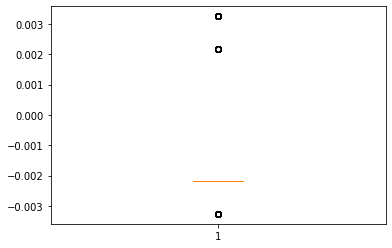

In [35]:
# calculate R
# R = P(gamma | r in M) / P(gamma | r in U)

t=[]
for cols, prob in zip(all_columns,initial_probability_book.values()):
    t.append(binom.pmf(cols,1,prob))
half = int(len(t) / 2)
t1 = t[0:half]
t2 = t[half:]

P_M = reduce(operator.mul, t1)
P_U = reduce(operator.mul, t2)
R = P_M / P_U

import matplotlib.pyplot as plt
R = np.log(R)
plt.boxplot(R)

match_criteria = R.max()

msk = R >= match_criteria

In [38]:
make_pairs(A,B)[msk]

,firstname_A,lastname_A,streetname_A,birthyear_A,firstname_B,lastname_B,streetname_B,birthyear_B
108,daniel,secuya,fairview ct,1957,ernesto,cristobal,fair ave,1981
195,daniel,secuya,fairview ct,1957,david,ali,fairfield ct,1979
283,daniel,secuya,fairview ct,1957,kevin,sajadi,fairview ave,1995
933,joseph,joseph,piedmont ave,1948,armando,akbar,piedmont ave apt n,1983
1009,joseph,joseph,piedmont ave,1948,derrick,johnston,piedmont ave apt 637,1941
...,...,...,...,...,...,...,...,...
169549,arlen,aaron,via rivera,1984,james,james,via primero,1959
171361,garth,patel,valais ct,1931,john,ripley-phipps,valley vista ct,1971
171946,christopher,cohen,brookside ave,1977,filbert,lopez,brookside dr,1993
172303,eler,murphy,olive ave,1928,abel,martin,olivina ave,1940
